# Developing a Miniature Version of Scikit-learn
In this notebook, we will compare the  execution speed and results of scikit-learn, an open-source machine learning library, and toy_sklearn, a miniature version of the former that I created as part of the coursework. While scikit-learn was referenced for deciding on methods, parameters, attributes and naming convensions to be included in the classes, the implementation itself is entirely my own. Numpy is the only open-source library used in toy_python.py.  
The classes and methods included in toy_sklearn are as follows:  
<pre>
linear_model    ––– LinearRegression   -–– fit  
                                           predict
                                           score
                ––– Ridge              ––– fit
                                           predict
                                           score
preprocessing   ––– PolynomialFeatures ––– transform
model_selection                        ––– train_test_split
                                       ––– cross_val_score
</pre>

In [1]:
#import necessary modules
import time
import toy_sklearn
import numpy as np
import matplotlib.pyplot as plt

We will use the Diabetes Dataset from sklearn.dataset to conduct the comparison.  


In [39]:
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)
X_0 = X[:,0].reshape(-1,1) # extract the first feature of X. make it a column vector
y = y.reshape(-1,1) # make it a column vector

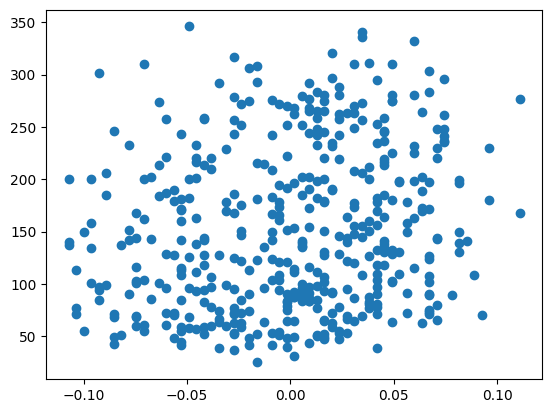

In [40]:
plt.scatter(X_0,y)


### 1. LinearRegression  

#### 1. Ordinary least square
Here we conduct ordinary least square to the Diabetes Dataset by toy_sklearn and sklearn and compare the results and execution time. We will only use the first feature of input data for simplicity.

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [101]:
#linear regression by toy_sklearn
start_toy = time.time()
X_train_toy, X_test_toy, y_train_toy, y_test_toy = toy_sklearn.model_selection.train_test_split(X_0, y, test_size=0.33, random_state=42) #split the data
model_toy = toy_sklearn.linear_model.LinearRegression() #create the model
model_toy.fit(X_train_toy, y_train_toy) #fit the model
toy_score = model_toy.score(X_test_toy, y_test_toy) #calculate the score
end_toy = time.time()

#linear regression by sklearn
start_sklearn = time.time()
X_train, X_test, y_train, y_test = train_test_split(X_0, y, test_size=0.33, random_state=42) #split the data
model = LinearRegression() #create the model
model.fit(X_train, y_train) #fit the model
score = model.score(X_test, y_test) #calculate the score
end_sklearn = time.time()

#display the results
print(f"toy_sklearn: coef={model_toy.coef_}, intercept={model_toy.intercept_}")
print(f"sklearn: coef={model.coef_}, intercept={model.intercept_}")
if model_toy.coef_ == model.coef_:
    print("The coefficients are the same")
else:
    print(f"The coefficients are different by {abs(model_toy.coef_-model.coef_)}")
if model_toy.intercept_ == model.intercept_:
    print("The intercepts are the same")
else:
    print(f"The intercepts are different by {abs(model_toy.intercept_-model.intercept_)}")
print(f"toy_sklearn: score={toy_score}")
print(f"sklearn: score={score}")
if toy_score == score:
    print("The scores are the same")
else:
    print(f"The scores are different by {abs(toy_score-score)}")
print(f"toy_sklearn execution time: {end_toy-start_toy}[s]")
print(f"sklearn execution time: {end_sklearn-start_sklearn}[s]")


if end_toy-start_toy < end_sklearn-start_sklearn:
    print(f"toy_sklearn is {round((end_sklearn-start_sklearn)/(end_toy-start_toy),2)} times faster than sklearn")
else:
    print(f"sklearn is {round((end_toy-start_toy)/(end_sklearn-start_sklearn),2)} times faster than toy_sklearn")

toy_sklearn: coef=[[293.26095691]], intercept=[151.63169998]
sklearn: coef=[[293.26095691]], intercept=[151.63169998]
The coefficients are the same
The intercepts are different by [2.84217094e-14]
toy_sklearn: score=0.0453315961729126
sklearn: score=0.0453315961729126
The scores are the same
toy_sklearn execution time: 0.002134084701538086[s]
sklearn execution time: 0.01123189926147461[s]
toy_sklearn is 5.26 times faster than sklearn


The coefficients and scores were the same, while the intercepts differed by a negligible amount, indicating that the LinearRegression implementation in toy_sklearn is accurate but employs different optimization strategies compared to sklearn.

#### 2. Polynomial regression
Here we conduct polynomial regression with degree 1 ~ 10 and select the best degree using cross validation. Then we conduct polynomial regression with the best degree to the entire train data and test data, and calculate the R2 score. We will only use the first feature of input data for simplicity.

In [43]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

In [99]:
degree_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# toy_sklearn implementation
start_toy = time.time()
# split the data
X_train_toy, X_test_toy, y_train_toy, y_test_toy = toy_sklearn.model_selection.train_test_split(X_0, y, test_size=0.33, random_state=40)
toy_score_list = []
for d in degree_list:
    poly = toy_sklearn.preprocessing.PolynomialFeatures(degree=d)
    X_poly_toy = poly.fit_transform(X_train_toy)  # transform training data
    model_toy = toy_sklearn.linear_model.LinearRegression()
    toy_score = sum(toy_sklearn.model_selection.cross_val_score(model_toy, X_poly_toy, y_train_toy, cv=5)) / 5  # CV on training set
    toy_score_list.append(toy_score)

best_degree_toy = degree_list[np.argmax(toy_score_list)]  # find the best degree
poly_toy = toy_sklearn.preprocessing.PolynomialFeatures(degree=best_degree_toy)
X_poly_train_toy = poly_toy.fit_transform(X_train_toy)
X_poly_test_toy = poly_toy.fit_transform(X_test_toy)  # transform the test set
model_toy = toy_sklearn.linear_model.LinearRegression()
model_toy.fit(X_poly_train_toy, y_train_toy)
toy_score = model_toy.score(X_poly_test_toy, y_test_toy)  # evaluate on the test set
end_toy = time.time()

# scikit-learn implementation
start_sklearn = time.time()
X_train, X_test, y_train, y_test = train_test_split(X_0, y, test_size=0.33, random_state=40)
score_list = []
for d in degree_list:
    poly = PolynomialFeatures(degree=d)
    X_poly_train = poly.fit_transform(X_train)  # Transform training data
    model = LinearRegression()
    score = cross_val_score(model, X_poly_train, y_train, cv=5).mean()  # CV on training set
    score_list.append(score)

best_degree = degree_list[np.argmax(score_list)]  # find the best degree
poly = PolynomialFeatures(degree=best_degree)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.fit_transform(X_test)  # Transform the test set
model = LinearRegression()
model.fit(X_poly_train, y_train)
score = model.score(X_poly_test, y_test)  # evaluate on the test set
end_sklearn = time.time()

#display the results
print(f"toy_sklearn: best degree={best_degree_toy}, cv score list: {toy_score_list}")
print(f"sklearn: best degree={best_degree}, cv score list: {score_list}")
print(f"toy_sklearn: coefficient={model_toy.coef_}, intercept={model_toy.intercept_}")
print(f"sklearn: coefficient={model.coef_}, intercept={model.intercept_}")
print(f"toy_sklearn: score={toy_score}")
print(f"sklearn: score={score}")
print(f"toy_sklearn execution time: {end_toy-start_toy}[s]")
print(f"sklearn execution time: {end_sklearn-start_sklearn}[s]")

if end_toy-start_toy < end_sklearn-start_sklearn:
    print(f"toy_sklearn is {round((end_sklearn-start_sklearn)/(end_toy-start_toy),2)} times faster than sklearn")
else:
    print(f"sklearn is {round((end_toy-start_toy)/(end_sklearn-start_sklearn),2)} times faster than toy_sklearn")


toy_sklearn: best degree=1, cv score list: [0.025379991626129295, 0.023506723262689676, 0.012911793320369203, 0.0009912271767299474, -0.0011792151272206342, 0.0041385039153003286, -0.019833792032023668, -0.034948962443154194, -0.4781502622429371, -1.1294285225793472]
sklearn: best degree=1, cv score list: [np.float64(0.026925819171022637), np.float64(0.025396067450528782), np.float64(0.01502564874479979), np.float64(0.004938877933946784), np.float64(0.0030899041312553834), np.float64(0.007048168466231264), np.float64(-0.020614668323675468), np.float64(-0.03264203191646027), np.float64(-0.4903010174848606), np.float64(-1.137812352638234)]
toy_sklearn: coefficient=[[351.45878694]], intercept=[147.20331773]
sklearn: coefficient=[[  0.         351.45878694]], intercept=[147.20331773]
toy_sklearn: score=-0.020191028325458937
sklearn: score=-0.020191028325458937
toy_sklearn execution time: 0.12445473670959473[s]
sklearn execution time: 0.11378884315490723[s]
sklearn is 1.09 times faster than

Although all the coefficients and scores were the same, the values in the cv score lists were different between the two modules. It is likely that sklearn.model_selection.cross_val splits data differently from toy_sklearn. As cross_val_score chose 1 as the best degree in both cases, we are yet to test whether toy_sklearn can conduct polynomial regression accurately. To test this, we will perform polynomial regression with degree 2 to 10 and see if the coefficients of all the cases are the same in both modules.

In [94]:
#polynomial regression with toy_sklearn
toy_score_list = []
toy_coef_list = []
toy_intercept_list = []

for d in range(2,11):
    poly = toy_sklearn.preprocessing.PolynomialFeatures(degree=d)
    X_poly_toy = poly.fit_transform(X_0)
    model_toy = toy_sklearn.linear_model.LinearRegression()
    model_toy.fit(X_poly_toy, y)
    toy_score = model_toy.score(X_poly_toy, y)
    toy_score_list.append(toy_score)
    toy_coef_list.append(model_toy.coef_)
    toy_intercept_list.append(model_toy.intercept_)

#polynomial regression with sklearn
score_list = []
coef_list = []
intercept_list = []
for d in range(2,11):
    poly = PolynomialFeatures(degree=d)
    X_poly = poly.fit_transform(X_0)
    model = LinearRegression()
    model.fit(X_poly, y)
    score = model.score(X_poly, y)
    score_list.append(score)
    
    model.coef_ = model.coef_[1:] #remove the first element(0) of the coef_ array
    coef_list.append(model.coef_.reshape(-1))
    intercept_list.append(model.intercept_)

#See if the results are the same
AreScoresSame = True
AreCoefsSame = True
AreInterceptsSame = True

for i in range(9):
    if toy_score_list[i] != score_list[i]:
        AreScoresSame *= False #if any of the scores are different, AreScoresSame will be False
        print(f"The scores at the degree {i+1} are different by |{toy_score_list[i]}- {score_list[i]}|= {abs(toy_score_list[i]-score_list[i])}")
    if not np.allclose(toy_coef_list[i], coef_list[i]):
        AreCoefsSame *= False #if any of the coefficients are different, AreCoefsSame will be False
        print(f"The coefficients at the degree {i+1} are different by |{toy_coef_list[i]}- {coef_list[i]}|= {abs(toy_coef_list[i]-coef_list[i])}")
    if toy_intercept_list[i][0] != intercept_list[i][0]:
        AreInterceptsSame *= False #if any of the intercepts are different, AreInterceptsSame will be False
        print(f"The intercepts at the degree {i+1} are different by |{toy_intercept_list[i]}- {intercept_list[i]}|= {abs(toy_intercept_list[i]-intercept_list[i])}")

print(f"Are the scores the same? {AreScoresSame}")
print(f"Are the coefficients the same? {AreCoefsSame}")
print(f"Are the intercepts the same? {AreInterceptsSame}")

The intercepts at the degree 1 are different by |[150.41970169]- [150.41970169]|= [1.42108547e-13]
The intercepts at the degree 2 are different by |[150.46282873]- [150.46282873]|= [1.98951966e-13]
The intercepts at the degree 3 are different by |[150.06706863]- [150.06706863]|= [1.98951966e-13]
The scores at the degree 4 are different by |0.03788903206532224- 0.037889032065322015|= 2.220446049250313e-16
The intercepts at the degree 4 are different by |[149.65802953]- [149.65802953]|= [5.68434189e-14]
The scores at the degree 5 are different by |0.040747036119747615- 0.04074703611974784|= 2.220446049250313e-16
The intercepts at the degree 5 are different by |[146.0922383]- [146.0922383]|= [5.68434189e-14]
The scores at the degree 6 are different by |0.04074722272596809- 0.04074722272596776|= 3.3306690738754696e-16
The intercepts at the degree 6 are different by |[146.08749883]- [146.08749883]|= [2.84217094e-14]
The scores at the degree 7 are different by |0.04088882345909173- 0.0408888

The intercepts and scores of the two methods differed by approximately 10e-13 and 10e-16 respectively. The difference is negligible, which suggests that the implementation of PolynomialFeatures and LinearRegression in toy_sklearn.py is correct, but that its calculation method is likely to be different from that of sklearn.

#### 3 Ridge regression  
Here we conduct ridge regression with regularisation parameter $\lambda = 10^{-5}, 10^{-4}, ... , 10^5$ and select the best $\lambda$ using cross validation. Then we conduct polynomial regression with the best degree to the entire train data and test data, and calculate the R2 score.

In [56]:
from sklearn.linear_model import Ridge

In [98]:
alpha_list = [10**i for i in range(-5,6)]

# Ridge regression by toy_sklearn
start_toy = time.time()
X_train_toy, X_test_toy, y_train_toy, y_test_toy = toy_sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42) #split the data
toy_score_list = []
for alpha in alpha_list:
    model_toy = toy_sklearn.linear_model.Ridge(alpha=alpha)
    toy_score = sum(toy_sklearn.model_selection.cross_val_score(model_toy, X_train_toy, y_train_toy, cv=5)) / 5
    toy_score_list.append(toy_score)

best_alpha_toy = alpha_list[np.argmax(toy_score_list)]
model_toy = toy_sklearn.linear_model.Ridge(alpha=best_alpha_toy)
model_toy.fit(X_train_toy, y_train_toy)
toy_score = model_toy.score(X_test_toy, y_test_toy)
end_toy = time.time()

# Ridge regression by scikit-learn
start_sklearn = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) #split the data
score_list = []
for alpha in alpha_list:
    model = Ridge(alpha=alpha)
    score = cross_val_score(model, X_train, y_train, cv=5).mean()
    score_list.append(score)

best_alpha = alpha_list[np.argmax(score_list)]
model = Ridge(alpha=best_alpha)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
end_sklearn = time.time()

#display the results
print(f"toy_sklearn: best alpha={best_alpha_toy}, cv score list: {toy_score_list}")
print(f"sklearn: best alpha={best_alpha}, cv score list: {score_list}")
print(f"toy_sklearn: coef={model_toy.coef_}, intercept={model_toy.intercept_}")
print(f"sklearn: coef={model.coef_}, intercept={model.intercept_}")
if model_toy.coef_.all() == model.coef_.all():
    print("The coefficients are the same")
else:
    print("The coefficients are different by ", abs(model_toy.coef_ - model.coef_))
if model_toy.intercept_ == model.intercept_:
    print("The intercepts are the same")
else:
    print("The intercepts are different by ", abs(model_toy.intercept_ - model.intercept_))
print(f"toy_sklearn: score={toy_score}")
print(f"sklearn: score={score}")
print(f"toy_sklearn execution time: {end_toy-start_toy}[s]")
print(f"sklearn execution time: {end_sklearn-start_sklearn}[s]")



if end_toy-start_toy < end_sklearn-start_sklearn:
    print(f"toy_sklearn is {round((end_sklearn-start_sklearn)/(end_toy-start_toy),2)} times faster than sklearn")
else:
    print(f"sklearn is {round((end_toy-start_toy)/(end_sklearn-start_sklearn),2)} times faster than toy_sklearn")

toy_sklearn: best alpha=0.001, cv score list: [0.4511555706379363, 0.4511732551325386, 0.4512455723973021, 0.4509520706632431, 0.45026707276787653, 0.3488182228931758, 0.08192814849901955, -0.3488583365992758, -2.5886755374091415, -3.777550194454329, -3.939819434307528]
sklearn: best alpha=0.001, cv score list: [np.float64(0.4519653783084445), np.float64(0.4519836587566207), np.float64(0.4520598980709646), np.float64(0.45175667405810954), np.float64(0.45098045435669254), np.float64(0.3495146503043767), np.float64(0.08767912739158557), np.float64(-0.009194158658647655), np.float64(-0.02154327493651571), np.float64(-0.022811999051528975), np.float64(-0.022939218658284986)]
toy_sklearn: coef=[[  32.97219943]
 [-241.81468957]
 [ 561.39527654]
 [ 406.43251078]
 [-632.19099008]
 [ 329.04080286]
 [ -27.25677536]
 [ 160.21062733]
 [ 593.01953251]
 [ -20.52446458]], intercept=[150.42206773]
sklearn: coef=[  32.97203821 -241.81475859  561.39484786  406.43255281 -632.19246656
  329.04199081  -27.

Similar to polynomial regression, the slight differences in the values within the CV score lists indicate variations in the implementation of cross_val_score. The coefficients of the two methods were identical, while the difference in the intercepts were not substantial and yet not negligible. This indicates that the implementation of Ridge in toy_sklearn is incorrect, or that sklearn employs an optimisation method that yields different results compared to an analytical method. 